# Effect of different sensitivity/contagion parameter on Expected Shortfall

## Balanced sectoral weighing

### Parameters

J = 3; N_firms = 1000

c = [0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.3]

r = 0.12
N = 12

5000 Monte Carlo Trials

### LGD $\sim$ Beta($\alpha$, $\beta$)

In [1]:
from ipynb.fs.full.stochastic_lgd import *

In [ ]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "balanced", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [4]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.333333  0.333333  0.333333
1     0.333333  0.333333  0.333333
2     0.333333  0.333333  0.333333
3     0.333333  0.333333  0.333333
4     0.333333  0.333333  0.333333
...        ...       ...       ...
995   0.333333  0.333333  0.333333
996   0.333333  0.333333  0.333333
997   0.333333  0.333333  0.333333
998   0.333333  0.333333  0.333333
999   0.333333  0.333333  0.333333

[1000 rows x 3 columns]


## Bullet Loan
repayment where the outstanding principal is repaid in full at the time of "maturity" (default).

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Bullet 445.163738 92.110611 603.679462 653.187323  49.507861        0.223306


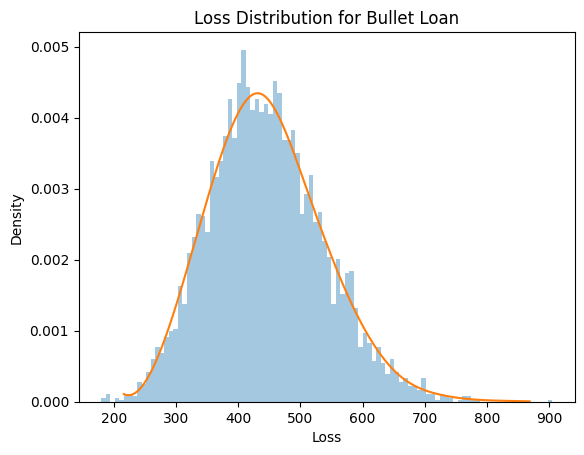

In [5]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

## French amortisation
repayment scheme where a constant total installment (Principal + Interest) throughout the life of the loan is paid

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
French 192.018098 39.743844 260.417556 282.877265  22.459709        0.252666


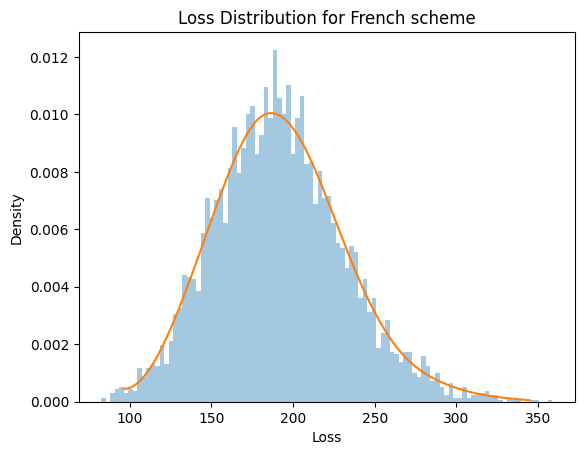

In [6]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')

## Linear (Italian) amortisation
repayment scheme characterised by a constant repayment of principal in each installment.

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Linear 187.916050 39.409301 254.868518 277.081173  22.212655        0.502242


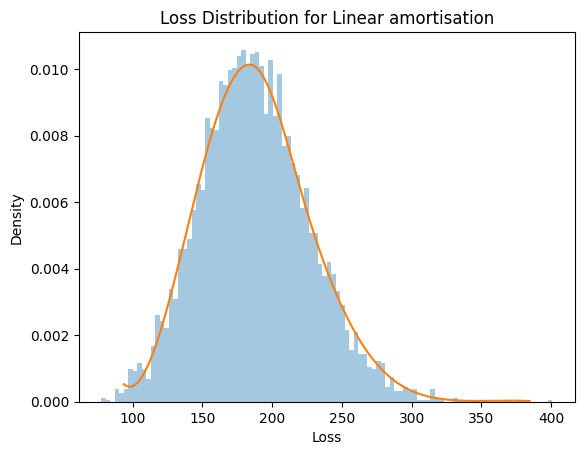

In [7]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear amortisation')

In [8]:
balancedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
balancedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,445.163738,92.110611,603.679462,653.187323,49.507861,0.223306
French,192.018098,39.743844,260.417556,282.877265,22.459709,0.252666
Linear,187.916050,39.409301,254.868518,277.081173,22.212655,0.502242


## Concentrated sectoral weighing

In [9]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "concentrated", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


In [10]:
params_df = pd.DataFrame({
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'lambda_benchmark': lambda_benchmark
}, index=[f'Sector_{j}' for j in range(J)])

print("Parameters per Sector:")
print(params_df)

print("\n\nPortfolio Weights (W):")
W_df = pd.DataFrame(W, columns=[f'Sector_{j}' for j in range(J)], index=pd.Index(range(N_firms), name='Firm'))
print(W_df)

Parameters per Sector:
            kappa    theta    sigma  lambda_benchmark
Sector_0 0.694378 0.048318 0.135817          0.259574
Sector_1 1.121571 0.049001 0.152923          0.229543
Sector_2 1.408060 0.014160 0.085078          0.076515


Portfolio Weights (W):
      Sector_0  Sector_1  Sector_2
Firm                              
0     0.700000  0.150000  0.150000
1     0.700000  0.150000  0.150000
2     0.700000  0.150000  0.150000
3     0.700000  0.150000  0.150000
4     0.700000  0.150000  0.150000
...        ...       ...       ...
995   0.700000  0.150000  0.150000
996   0.700000  0.150000  0.150000
997   0.700000  0.150000  0.150000
998   0.700000  0.150000  0.150000
999   0.700000  0.150000  0.150000

[1000 rows x 3 columns]


## Bullet Loan
repayment where the outstanding principal is repaid in full at the time of "maturity" (default).

             Mean        Std         VaR          ES  Excess ES  \
Bullet 781.633327 179.960554 1091.129762 1179.405180  88.275418   

        ExcessKurtosis  
Bullet        0.031806  


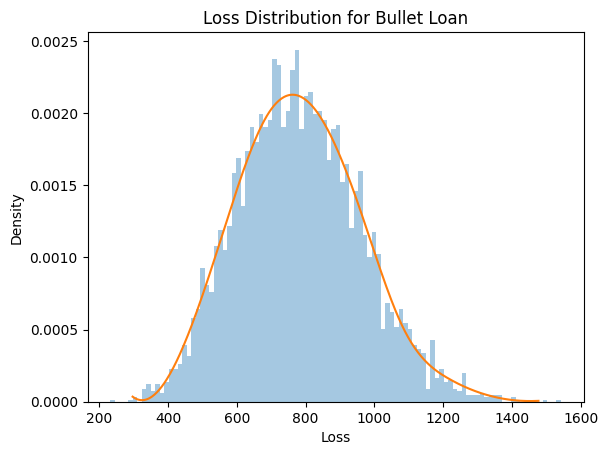

In [11]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

## French amortisation
repayment scheme where a constant total installment (Principal + Interest) throughout the life of the loan is paid

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
French 272.897670 65.893379 388.482154 425.436596  36.954442        0.282166


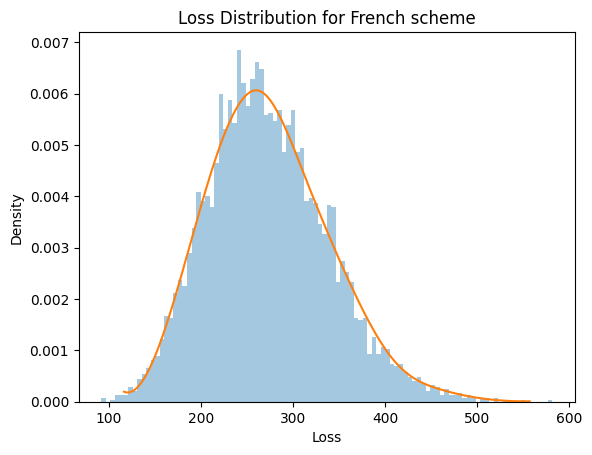

In [12]:

loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')


## Linear (Italian) amortisation
repayment scheme characterised by a constant repayment of principal in each installment.


             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Linear 265.093398 63.913127 377.477874 410.030248  32.552374        0.177067


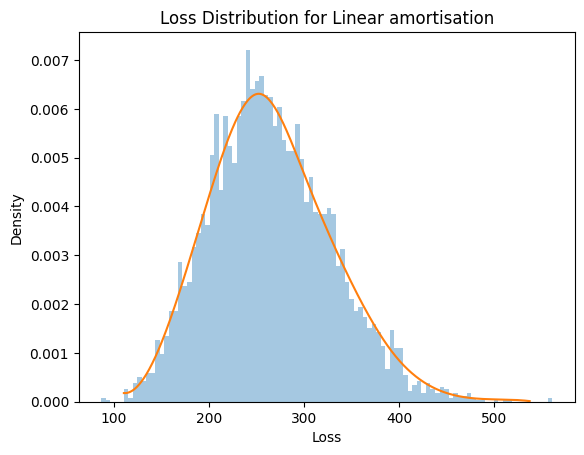

In [13]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear amortisation')

In [14]:
concentratedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
concentratedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,781.633327,179.960554,1091.129762,1179.405180,88.275418,0.031806
French,272.897670,65.893379,388.482154,425.436596,36.954442,0.282166
Linear,265.093398,63.913127,377.477874,410.030248,32.552374,0.177067


## Random sectoral weighing

In [15]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "random", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Bullet 449.089368 93.172195 610.773568 655.745775  44.972207        0.099078


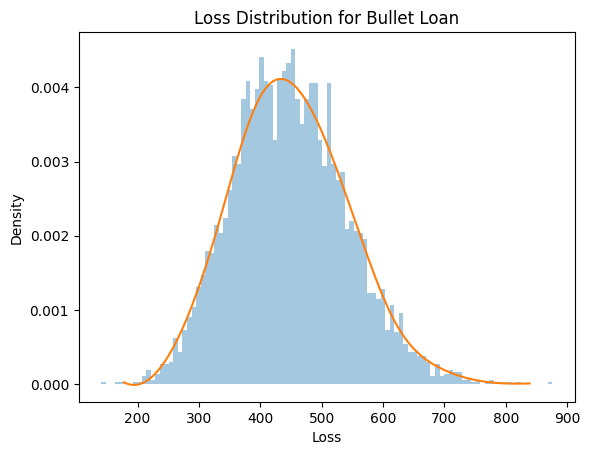

In [16]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
French 192.398166 40.783516 262.104507 284.586666  22.482159        0.201668


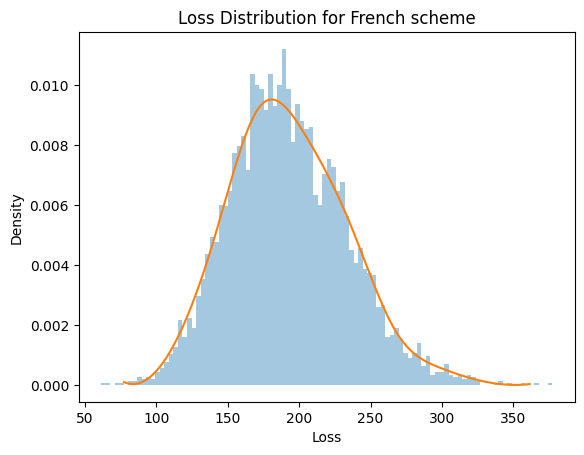

In [17]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')


             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Linear 187.922346 39.244939 255.931028 274.357134  18.426106        0.020804


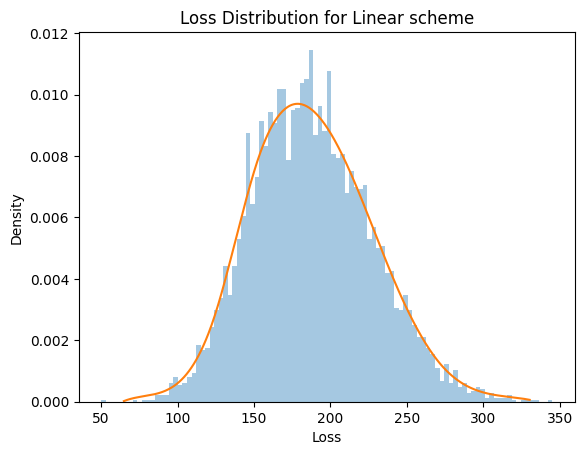

In [18]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear scheme')

In [19]:
randomsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
randomsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,449.089368,93.172195,610.773568,655.745775,44.972207,0.099078
French,192.398166,40.783516,262.104507,284.586666,22.482159,0.201668
Linear,187.922346,39.244939,255.931028,274.357134,18.426106,0.020804


## Mixed sectors

In [20]:
rng = np.random.default_rng(1265883927568217)

N_firms = 1000
J = 3

c = 0.01

T = 1

NUM_TRIALS = 5000

kappa = rng.uniform(0.5, 1.5, J)
theta = rng.uniform(0.001, 0.051, J)
sigma_inter = rng.uniform(0.0, 0.2, J)
sigma = np.minimum(np.sqrt(2*kappa*theta), sigma_inter)

idio_factor = rng.uniform(0.01, 0.03, N_firms)

feller = (2 * kappa * theta) / (sigma**2)
print("Feller condition (should be >=1):", feller)

W = generate_portfolio_weights(N_firms, J, "mixed", rng=rng)

delta = c * W

lambda_benchmark = np.array([
    lambda_max_generator(1e-4, theta[j], theta[j],
                         sigma[j], kappa[j])
    for j in range(J)
])


params = {
    'Firms': N_firms,
    'Sectors': J,
    'Global Senstivity Param': c,
    'kappa': kappa,
    'theta': theta,
    'sigma': sigma,
    'delta': delta,
    'lambda_benchmark': lambda_benchmark,
    'idio_factor': idio_factor,
    'W': W,
    'T': T
}

Feller condition (should be >=1): [3.637663 4.700201 5.508869]


             Mean        Std        VaR         ES  Excess ES  ExcessKurtosis
Bullet 539.646556 117.867104 746.338253 806.684472  60.346219        0.281347


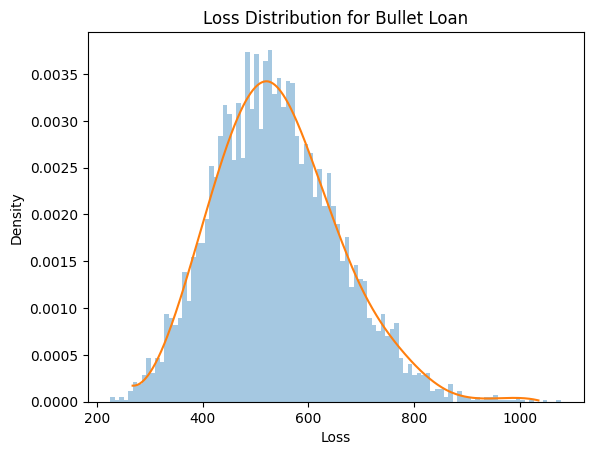

In [21]:
loan_b = [
    {
        "type": 'bullet',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_b = run_simulation(params, loan_b, num_trials=NUM_TRIALS)
metrics_b = compute_metrics(losses_b, alpha=0.95)
metrics_b_df = pd.DataFrame(metrics_b, index=['Bullet'])
print(metrics_b_df)

loss_distribution_plot(losses_b, 'Bullet Loan')

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
French 221.590563 47.159019 304.807786 326.763548  21.955762        0.123479


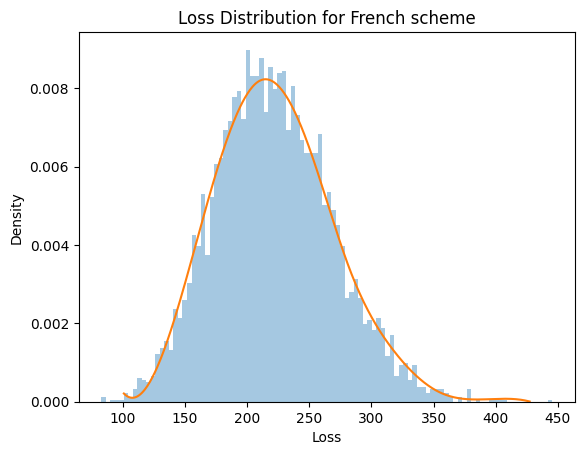

In [22]:
loan_f = [
    {
        "type": 'french',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_f = run_simulation(params, loan_f, num_trials=NUM_TRIALS)
metrics_f = compute_metrics(losses_f, alpha=0.95)
metrics_f_df = pd.DataFrame(metrics_f, index=['French'])
print(metrics_f_df)

loss_distribution_plot(losses_f, 'French scheme')

             Mean       Std        VaR         ES  Excess ES  ExcessKurtosis
Linear 214.472366 46.103117 295.600637 318.597708  22.997071        0.210068


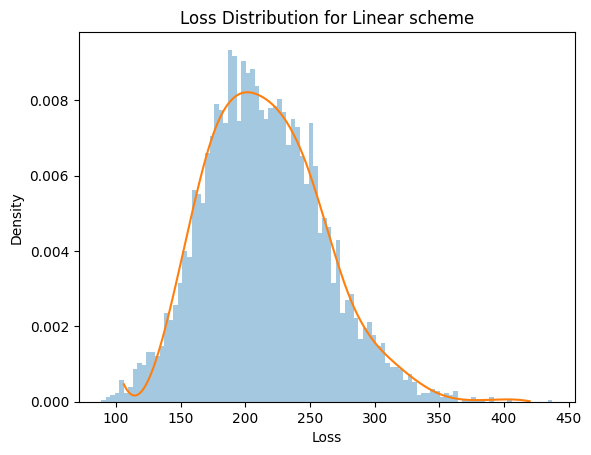

In [23]:
loan_l = [
    {
        "type": 'linear',
        "P": 10.0,
        "N": 12,
        "r": 0.12,
    }
    for i in range(N_firms)
]

losses_l = run_simulation(params, loan_l, num_trials=NUM_TRIALS)
metrics_l = compute_metrics(losses_l, alpha=0.95)
metrics_l_df = pd.DataFrame(metrics_l, index=['Linear'])
print(metrics_l_df)

loss_distribution_plot(losses_l, 'Linear scheme')

In [24]:
mixedsectors_df = pd.concat([metrics_b_df, metrics_f_df, metrics_l_df])
mixedsectors_df

,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis
Bullet,539.646556,117.867104,746.338253,806.684472,60.346219,0.281347
French,221.590563,47.159019,304.807786,326.763548,21.955762,0.123479
Linear,214.472366,46.103117,295.600637,318.597708,22.997071,0.210068


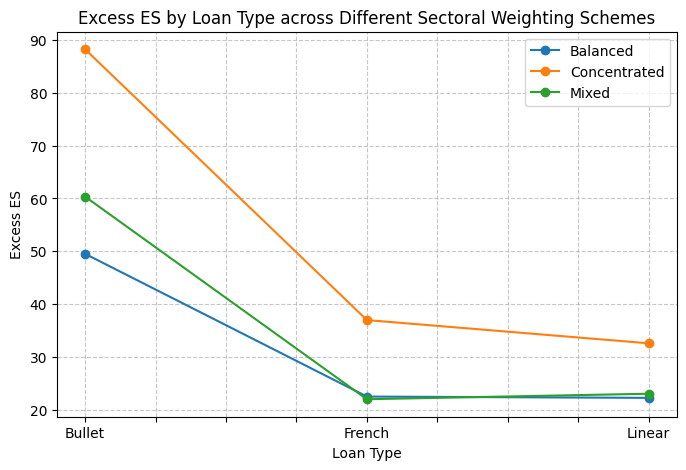

In [25]:
excess_es_df = pd.DataFrame({
    'Balanced': balancedsectors_df['Excess ES'],
    'Concentrated': concentratedsectors_df['Excess ES'],
    # 'Random': randomsectors_df['Excess ES'],
    'Mixed': mixedsectors_df['Excess ES']
})

ax = excess_es_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('Excess ES')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('Excess ES by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()


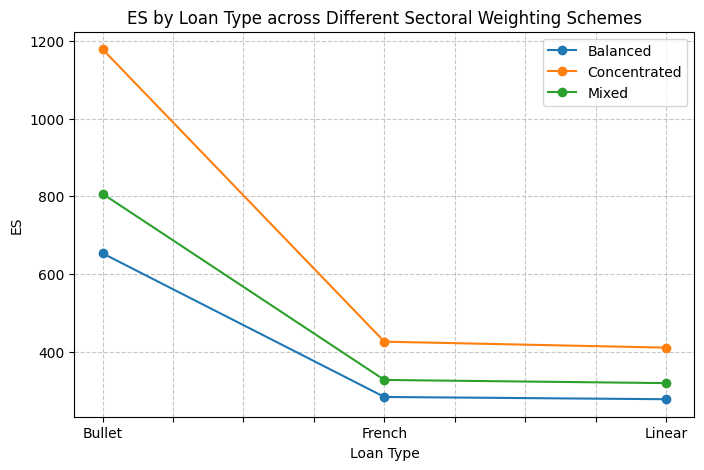

In [26]:
es_df = pd.DataFrame({
    'Balanced': balancedsectors_df['ES'],
    'Concentrated': concentratedsectors_df['ES'],
    # 'Random': randomsectors_df['Excess ES'],
    'Mixed': mixedsectors_df['ES']
})

ax = es_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('ES')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('ES by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()


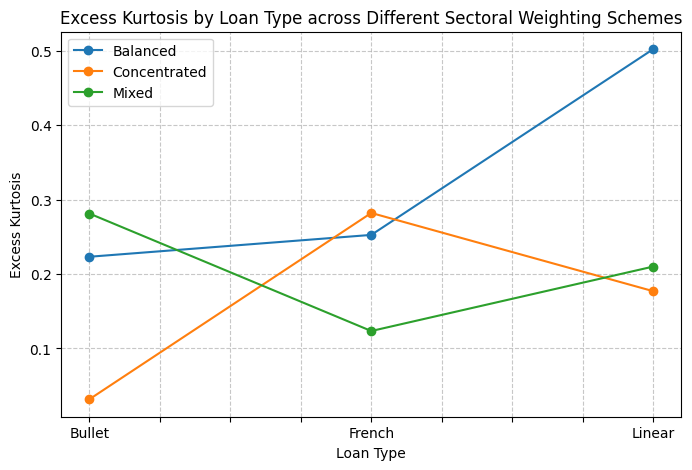

In [27]:
k_df = pd.DataFrame({
    'Balanced': balancedsectors_df['ExcessKurtosis'],
    'Concentrated': concentratedsectors_df['ExcessKurtosis'],
    # 'Random': randomsectors_df['ExcessKurtosis'],
    'Mixed': mixedsectors_df['ExcessKurtosis']
})

ax = k_df.plot(kind='line', marker='o', figsize=(8, 5))
ax.set_ylabel('Excess Kurtosis')
ax.set_xlabel('Loan Type')
ax.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.title('Excess Kurtosis by Loan Type across Different Sectoral Weighting Schemes')
#plt.tight_layout()
plt.show()


In [2]:
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed

# Parameter sweep across c values, weighting schemes, and loan types
BASE_SEED = 1265883927568217
C_GRID = np.array([0.005, 0.008, 0.01, 0.03, 0.05, 0.1, 0.3], dtype=float)
WEIGHTINGS = ["balanced", "concentrated", "random"]
LOAN_TEMPLATES = {
    "Bullet": {"type": "bullet", "P": 10.0, "N": 12, "r": 0.12},
    "French": {"type": "french", "P": 10.0, "N": 12, "r": 0.12},
    "Linear": {"type": "linear", "P": 10.0, "N": 12, "r": 0.12},
}

N_FIRMS = 1000
J = 3
T = 1
NUM_TRIALS = 1000  
ALPHA = 0.95
MAX_WORKERS = 6 


def build_params(weighting: str, c_value: float, seed_base: int = BASE_SEED):
    """Create parameter set for a weighting scheme and contagion level."""
    seed_seq = np.random.SeedSequence(seed_base, spawn_key=[WEIGHTINGS.index(weighting), int(c_value * 1e6)])
    rng = np.random.default_rng(seed_seq)
    kappa = rng.uniform(0.5, 1.5, J)
    theta = rng.uniform(0.001, 0.051, J)
    sigma_inter = rng.uniform(0.0, 0.2, J)
    sigma = np.minimum(np.sqrt(2 * kappa * theta), sigma_inter)
    idio_factor = rng.uniform(0.01, 0.03, N_FIRMS)
    W = generate_portfolio_weights(N_FIRMS, J, weighting, rng=rng)
    delta = c_value * W
    lambda_benchmark = np.array([
        lambda_max_generator(1e-4, theta[j], theta[j], sigma[j], kappa[j])
        for j in range(J)
    ])
    return {
        "Firms": N_FIRMS,
        "Sectors": J,
        "Global Senstivity Param": c_value,
        "kappa": kappa,
        "theta": theta,
        "sigma": sigma,
        "delta": delta,
        "lambda_benchmark": lambda_benchmark,
        "idio_factor": idio_factor,
        "W": W,
        "T": T,
    }


def simulate_combo(weighting: str, c_value: float, loan_name: str, loan_template: dict):
    params = build_params(weighting, c_value)
    loan = [loan_template.copy() for _ in range(N_FIRMS)]
    losses = run_simulation(params, loan, num_trials=NUM_TRIALS)
    metrics = compute_metrics(losses, alpha=ALPHA)
    metrics.update({
        "weighting": weighting,
        "c": c_value,
        "loan_type": loan_name,
    })
    return metrics


def run_parallel_sweep():
    tasks = []
    for weighting, c_value in itertools.product(WEIGHTINGS, C_GRID):
        for loan_name, loan_template in LOAN_TEMPLATES.items():
            tasks.append((weighting, c_value, loan_name, loan_template))

    results = []
    with ThreadPoolExecutor(max_workers=min(MAX_WORKERS, len(tasks))) as executor:
        future_to_task = {
            executor.submit(simulate_combo, w, c_val, ln, tmpl): (w, c_val, ln)
            for (w, c_val, ln, tmpl) in tasks
        }
        total = len(future_to_task)
        for i, future in enumerate(as_completed(future_to_task), 1):
            results.append(future.result())
            if i % 5 == 0 or i == total:
                print(f"Completed {i}/{total} tasks")
    return pd.DataFrame(results)


metrics_grid_df = run_parallel_sweep().sort_values(["c", "weighting", "loan_type"]).reset_index(drop=True)
metrics_grid_df

Completed 5/63 tasks
Completed 10/63 tasks
Completed 15/63 tasks
Completed 20/63 tasks
Completed 25/63 tasks
Completed 30/63 tasks
Completed 35/63 tasks
Completed 40/63 tasks
Completed 45/63 tasks
Completed 50/63 tasks
Completed 55/63 tasks
Completed 60/63 tasks
Completed 63/63 tasks


,Mean,Std,VaR,ES,Excess ES,ExcessKurtosis,weighting,c,loan_type
0,260.431660,58.532500,362.307675,398.325973,36.018298,0.518676,balanced,0.005000,Bullet
1,129.332533,29.171075,176.627047,192.864668,16.237621,0.018803,balanced,0.005000,French
2,126.015459,28.171012,176.001672,188.231368,12.229696,0.094915,balanced,0.005000,Linear
3,279.332442,60.271777,386.272040,416.697367,30.425327,0.351972,concentrated,0.005000,Bullet
4,125.350565,28.873673,177.938805,190.149419,12.210614,0.110557,concentrated,0.005000,French
...,...,...,...,...,...,...,...,...,...
58,4172.520905,118.583159,4344.885432,4383.745934,38.860502,2.254757,concentrated,0.300000,French
59,4153.957020,124.034881,4333.709292,4373.968434,40.259142,2.283114,concentrated,0.300000,Linear
60,4500.153789,47.123836,4577.892416,4597.601084,19.708668,-0.110287,random,0.300000,Bullet
61,3915.125709,158.429816,4130.917418,4164.058196,33.140778,1.499211,random,0.300000,French


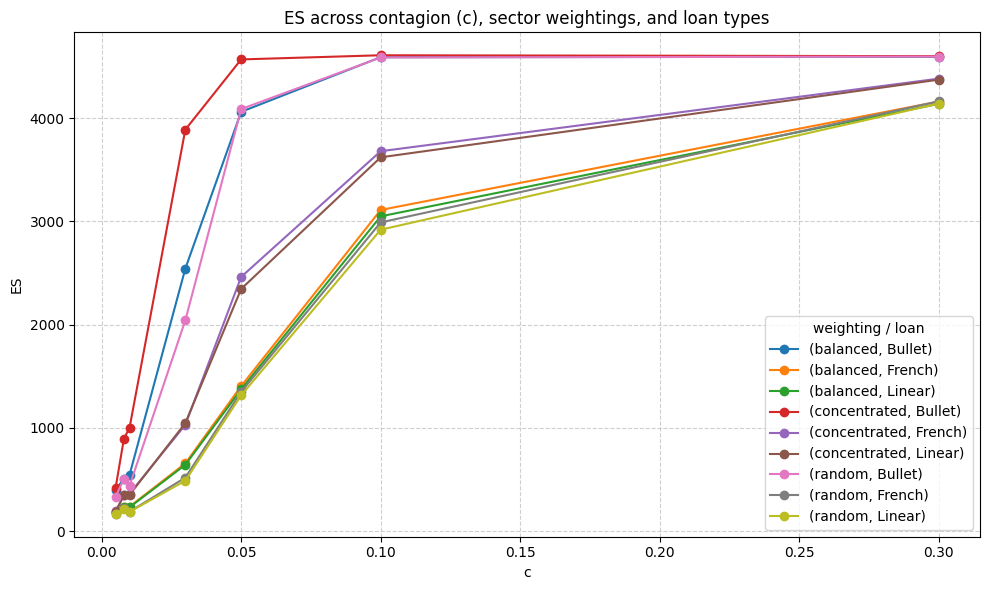

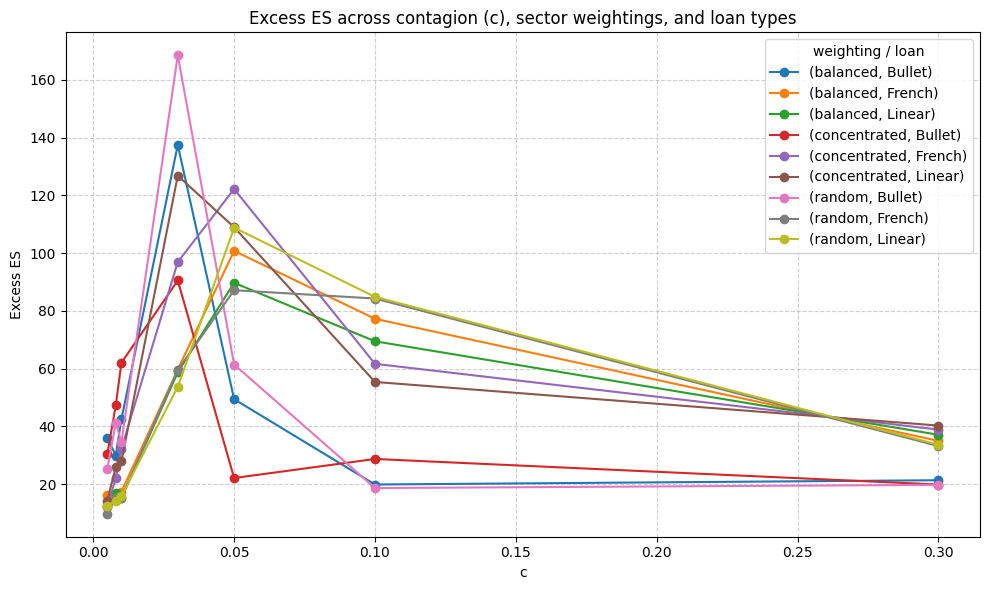

In [3]:
es_pivot = metrics_grid_df.pivot_table(index="c", columns=["weighting", "loan_type"], values="ES")
excess_es_pivot = metrics_grid_df.pivot_table(index="c", columns=["weighting", "loan_type"], values="Excess ES")

ax = es_pivot.plot(kind="line", marker="o", figsize=(10, 6))
ax.set_title("ES across contagion (c), sector weightings, and loan types")
ax.set_ylabel("ES")
ax.set_xlabel("c")
ax.grid(linestyle="--", alpha=0.6)
plt.legend(title="weighting / loan")
plt.tight_layout()
plt.show()

ax2 = excess_es_pivot.plot(kind="line", marker="o", figsize=(10, 6))
ax2.set_title("Excess ES across contagion (c), sector weightings, and loan types")
ax2.set_ylabel("Excess ES")
ax2.set_xlabel("c")
ax2.grid(linestyle="--", alpha=0.6)
plt.legend(title="weighting / loan")
plt.tight_layout()
plt.show()

In [4]:
LINESTYLES = {
    "balanced": "-",
    "concentrated": "--",
    "random": ":",
}

MARKERS = {
    "Bullet": "o",
    "French": "s",
    "Linear": "^",
}


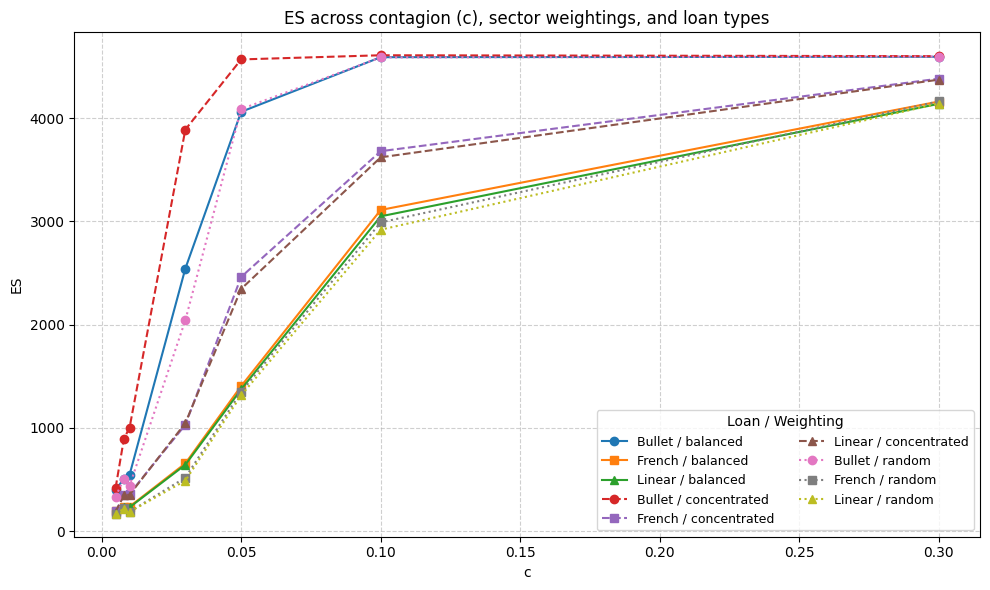

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

for weighting in WEIGHTINGS:
    for loan_type in LOAN_TEMPLATES.keys():
        df_sub = metrics_grid_df[
            (metrics_grid_df["weighting"] == weighting) &
            (metrics_grid_df["loan_type"] == loan_type)
        ].sort_values("c")

        ax.plot(
            df_sub["c"],
            df_sub["ES"],
            linestyle=LINESTYLES[weighting],
            marker=MARKERS[loan_type],
            label=f"{loan_type} / {weighting}",
        )

ax.set_title("ES across contagion (c), sector weightings, and loan types")
ax.set_xlabel("c")
ax.set_ylabel("ES")
ax.grid(linestyle="--", alpha=0.6)

# Compact legend
ax.legend(
    title="Loan / Weighting",
    ncol=2,
    fontsize=9,
    title_fontsize=10,
)

plt.tight_layout()
plt.show()


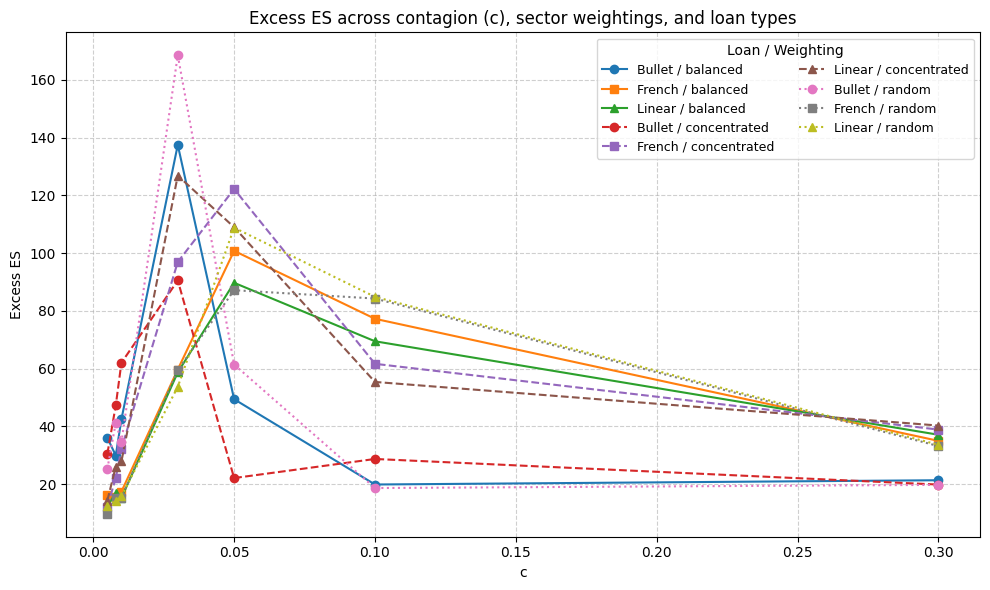

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for weighting in WEIGHTINGS:
    for loan_type in LOAN_TEMPLATES.keys():
        df_sub = metrics_grid_df[
            (metrics_grid_df["weighting"] == weighting) &
            (metrics_grid_df["loan_type"] == loan_type)
        ].sort_values("c")

        ax.plot(
            df_sub["c"],
            df_sub["Excess ES"],
            linestyle=LINESTYLES[weighting],
            marker=MARKERS[loan_type],
            label=f"{loan_type} / {weighting}",
        )

ax.set_title("Excess ES across contagion (c), sector weightings, and loan types")
ax.set_xlabel("c")
ax.set_ylabel("Excess ES")
ax.grid(linestyle="--", alpha=0.6)

ax.legend(
    title="Loan / Weighting",
    ncol=2,
    fontsize=9,
    title_fontsize=10,
)

plt.tight_layout()
plt.show()
